# **Imports**

In [191]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import (DataLoader,Dataset)
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from tqdm import tqdm
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
from sklearn.metrics import confusion_matrix
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt
from torchvision.models import vgg19
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.transforms import ToPILImage

In [192]:
from google.colab import drive
drive.mount('/content/drive')

!unzip "/content/drive/MyDrive/Dataset.zip" -d "/content/Dataset"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/MyDrive/Dataset.zip
replace /content/Dataset/Dataset/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# **Visualizations**

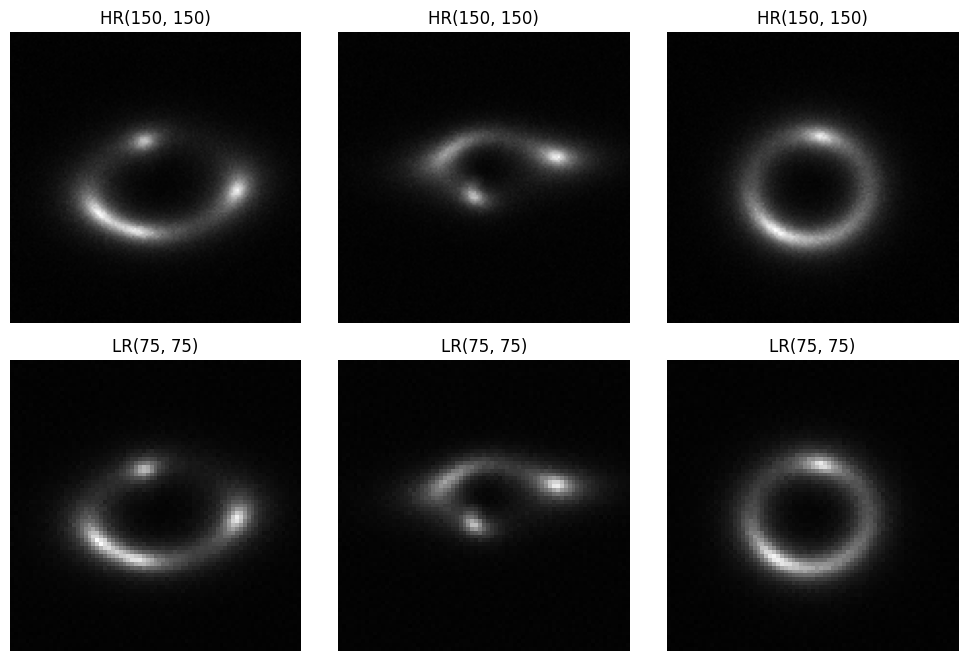

In [193]:
subfolders = ["HR", "LR"]
n_images = 3
fig = plt.figure(figsize=(10,10))

x = 0
for i, subfolder in enumerate(subfolders):

    image_files = os.listdir(os.path.join("/content/Dataset/Dataset/", subfolder))

    for j, image_file in enumerate(image_files[:n_images]):

        img_array = np.load(os.path.join("/content/Dataset/Dataset/", subfolder, image_file))
        img = Image.fromarray((img_array[0] * 255).astype(np.uint8))
        ax = fig.add_subplot(3, 3, i*3 + j + 1)
        plt.axis("off")
        ax.imshow(img, cmap='gray', vmin=0, vmax=255)
        ax.set_title(subfolder+str(img.size))


plt.tight_layout()

plt.show()

# **Model Definition**

In [194]:
class Conv(nn.Module):
  def __init__(self, in_c, out_c, **kwargs):
      super().__init__()
      self.cnn = nn.Conv2d(in_c, out_c, **kwargs)
      self.actication = nn.PReLU(num_parameters=out_c)

  def forward(self, x):
      x = self.cnn(x)
      x = self.actication(x)
      return x

In [195]:
class Upsample(nn.Module):
  def __init__(self, in_c, scale_factor):
      super().__init__()
      self.conv = nn.Conv2d(in_c, in_c * scale_factor ** 2, kernel_size=3, stride=1, padding=1)
      self.pixel_shuffle = nn.PixelShuffle(scale_factor)
      self.activation = nn.PReLU(num_parameters=in_c)

  def forward(self, x):
      x = self.conv(x)
      x = self.pixel_shuffle(x)
      x = self.activation(x)
      return x

In [196]:
class RBlock(nn.Module):
  def __init__(self, in_c):
      super().__init__()
      self.b1 = Conv(in_c, in_c, kernel_size=3, stride=1, padding=1)
      self.b2 = Conv(in_c, in_c, kernel_size=3, stride=1, padding=1)

  def forward(self, x):
      b1_output = self.b1(x)
      b2_output = self.b2(b1_output)
      return b2_output + x

In [197]:
class Generator(nn.Module):
  def __init__(self, in_c=1, out_c=64, no_blocks=1):
      super().__init__()
      self.first_conv = Conv(in_c, out_c, kernel_size=9, stride=1, padding=4)
      res_blocks = []
      for _ in range(no_blocks):
          res_blocks.append(RBlock(64))
      self.res_blocks = nn.Sequential(*res_blocks)
      self.conv1 = Conv(out_c, out_c, kernel_size=3, stride=1, padding=1)

      self.upsampling = Upsample(out_c, scale_factor=2)
      self.last_conv = nn.Conv2d(out_c, in_c, kernel_size=3, stride=1, padding=1)

  def forward(self,x):
      first_conv = self.first_conv(x)
      x = self.res_blocks(first_conv)
      x = self.conv1(x) + first_conv
      x = self.upsampling(x)
      x = self.last_conv(x)
      return x

# **Metrics**

In [198]:
def psnr(img1, img2):
    with torch.no_grad():
      img1 = torch.from_numpy(np.asarray(img1))
      img2 = torch.from_numpy(np.asarray(img2))

      mse_s = mse(img1,img2)
      if mse_s == 0:
          return 100
      PIXEL_MAX = 1
      psnr = 20 * torch.log10(PIXEL_MAX / torch.sqrt(mse_s))
      return psnr

In [199]:
def ssim(img1, img2):
    img1 = torch.from_numpy(np.asarray(img1))
    img2 = torch.from_numpy(np.asarray(img2))
    window_size = 11
    sigma = 1.5
    channel = img1.size(1)
    weight = torch.Tensor(channel, 1, window_size, window_size)
    weight.fill_(1.0 / (channel * window_size ** 2))

    mu1 = F.conv2d(img1, weight, padding = window_size // 2, groups = channel)
    mu2 = F.conv2d(img2, weight, padding = window_size // 2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, weight, padding = window_size // 2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, weight, padding = window_size // 2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, weight, padding = window_size // 2, groups = channel) - mu1_mu2

    C1 = (0.01) ** 2
    C2 = (0.03) ** 2

    ssim_score = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    return ssim_score.mean()

# **Data Loader**

In [200]:
hr_dir = "/content/Dataset/Dataset/HR"
lr_dir = "/content/Dataset/Dataset/LR"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class MyDataset(Dataset):
  def __init__(self, hr_dir=hr_dir, lr_dir=lr_dir):
    self.hr_dir = hr_dir
    self.lr_dir = lr_dir
  
    self.hr_files = os.listdir(hr_dir)
    self.hr_files.sort()
    self.lr_files = os.listdir(lr_dir)
    self.lr_files.sort()
  def __len__(self):
    return len(self.hr_files)
  
  def __getitem__(self, index):
    hr_file = self.hr_files[index]
    lr_file = self.lr_files[index]

    hr_image = np.load(os.path.join(self.hr_dir, hr_file)).astype(np.float32)
    lr_image = np.load(os.path.join(self.lr_dir, lr_file)).astype(np.float32)

    return hr_image, lr_image

In [201]:
dataset = MyDataset()

total_count = len(dataset)
train_count = int(0.9 * total_count)
test_count = total_count - train_count
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, (train_count, test_count)
)

loader = DataLoader(train_dataset, batch_size=16,shuffle=False)
val_loader = DataLoader(test_dataset,batch_size=16,shuffle=False)

In [202]:
model = Generator().to(device)
model_opt = optim.Adam(model.parameters(),lr=1e-4)
mse = nn.MSELoss()
bce = nn.BCEWithLogitsLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(model_opt, mode='min', factor=0.9, patience=4)

# **Evaluation**

In [203]:
def evaluate(model,dataloader):
  model.eval()
  losses = []
  ssim_scores = []
  psnr_scores = []
  with torch.no_grad():
    for hr_image,lr_image in dataloader:
       hr_image = hr_image.to(device)
       lr_image = lr_image.to(device)
       generated = model(lr_image)

       mse_loss = mse(generated,hr_image)
       losses.append(mse_loss.item())

       psnr_s = psnr(hr_image.detach().cpu().numpy(),generated.detach().cpu().numpy())
       
       psnr_scores.append(psnr_s)

       ssim_s = ssim(hr_image.detach().cpu().numpy(),generated.detach().cpu().numpy())
       ssim_scores.append(ssim_s.item())

    avg_loss = sum(losses) / len(losses)
    avg_psnr = sum(psnr_scores) / len(psnr_scores)
    avg_ssim = sum(ssim_scores) / len(ssim_scores)

    return avg_loss, avg_psnr, avg_ssim

# **Model Training**

In [204]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [205]:
best_pnsr = 0
for epoch in range(30):

  losses = []

  model.train()
  for hr_image,lr_image in tqdm(loader):
    
    hr_image = hr_image.to(device)
    lr_image = lr_image.to(device)

    generated = model(lr_image)
    mse_loss = mse(generated,hr_image)
    losses.append(mse_loss.item())

    model_opt.zero_grad()
    mse_loss.backward()
    model_opt.step()



  avg_loss = sum(losses) / len(losses)
  
  avg_val_loss, avg_val_psnr, avg_val_ssim = evaluate(model,val_loader)
  if avg_val_psnr < best_pnsr:
        # Update the best validation score
        best_pnsr = avg_val_psnr
        
        # Save the model state dictionary and other information
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': model_opt.state_dict(),
            'val_score': avg_val_psnr
        }, 'best_model.pth')
  scheduler.step(avg_val_loss)
  print(f"\nEpoch No. {1+epoch}\n======\n")
  print(f"Training Loss is {avg_loss:.7f}, Validation Loss is {avg_val_loss:.7f}")
  print(f"Validation PSNR is {avg_val_psnr:.7f}")
  print(f"Validation SSIM is {avg_val_ssim:.7f}")
  print("===============\n")

100%|██████████| 563/563 [00:24<00:00, 22.75it/s]



Epoch No. 1

Training Loss is 0.0003806, Validation Loss is 0.0000781
Validation PSNR is 41.0775757
Validation SSIM is 0.9777043



100%|██████████| 563/563 [00:24<00:00, 22.85it/s]



Epoch No. 2

Training Loss is 0.0000747, Validation Loss is 0.0000725
Validation PSNR is 41.3992043
Validation SSIM is 0.9789272



100%|██████████| 563/563 [00:24<00:00, 22.76it/s]



Epoch No. 3

Training Loss is 0.0000691, Validation Loss is 0.0000666
Validation PSNR is 41.7657700
Validation SSIM is 0.9803868



100%|██████████| 563/563 [00:24<00:00, 22.64it/s]



Epoch No. 4

Training Loss is 0.0000645, Validation Loss is 0.0000621
Validation PSNR is 42.0693092
Validation SSIM is 0.9817623



100%|██████████| 563/563 [00:24<00:00, 22.59it/s]



Epoch No. 5

Training Loss is 0.0000621, Validation Loss is 0.0000606
Validation PSNR is 42.1762123
Validation SSIM is 0.9823006



100%|██████████| 563/563 [00:24<00:00, 22.57it/s]



Epoch No. 6

Training Loss is 0.0000611, Validation Loss is 0.0000602
Validation PSNR is 42.2092972
Validation SSIM is 0.9824663



100%|██████████| 563/563 [00:25<00:00, 22.51it/s]



Epoch No. 7

Training Loss is 0.0000608, Validation Loss is 0.0000597
Validation PSNR is 42.2387199
Validation SSIM is 0.9826387



100%|██████████| 563/563 [00:25<00:00, 22.48it/s]



Epoch No. 8

Training Loss is 0.0000599, Validation Loss is 0.0000598
Validation PSNR is 42.2367058
Validation SSIM is 0.9826187



100%|██████████| 563/563 [00:25<00:00, 22.46it/s]



Epoch No. 9

Training Loss is 0.0000601, Validation Loss is 0.0000595
Validation PSNR is 42.2546959
Validation SSIM is 0.9826752



100%|██████████| 563/563 [00:25<00:00, 22.46it/s]



Epoch No. 10

Training Loss is 0.0000600, Validation Loss is 0.0000595
Validation PSNR is 42.2584953
Validation SSIM is 0.9827308



100%|██████████| 563/563 [00:25<00:00, 22.43it/s]



Epoch No. 11

Training Loss is 0.0000600, Validation Loss is 0.0000592
Validation PSNR is 42.2777863
Validation SSIM is 0.9827744



100%|██████████| 563/563 [00:25<00:00, 22.46it/s]



Epoch No. 12

Training Loss is 0.0000597, Validation Loss is 0.0000591
Validation PSNR is 42.2889442
Validation SSIM is 0.9828321



100%|██████████| 563/563 [00:25<00:00, 22.41it/s]



Epoch No. 13

Training Loss is 0.0000594, Validation Loss is 0.0000595
Validation PSNR is 42.2577362
Validation SSIM is 0.9827880



100%|██████████| 563/563 [00:25<00:00, 22.41it/s]



Epoch No. 14

Training Loss is 0.0000597, Validation Loss is 0.0000590
Validation PSNR is 42.2899475
Validation SSIM is 0.9828528



100%|██████████| 563/563 [00:25<00:00, 22.40it/s]



Epoch No. 15

Training Loss is 0.0000595, Validation Loss is 0.0000589
Validation PSNR is 42.2978668
Validation SSIM is 0.9828870



100%|██████████| 563/563 [00:25<00:00, 22.43it/s]



Epoch No. 16

Training Loss is 0.0000593, Validation Loss is 0.0000590
Validation PSNR is 42.2923050
Validation SSIM is 0.9828850



100%|██████████| 563/563 [00:25<00:00, 22.41it/s]



Epoch No. 17

Training Loss is 0.0000594, Validation Loss is 0.0000592
Validation PSNR is 42.2820663
Validation SSIM is 0.9828327



100%|██████████| 563/563 [00:25<00:00, 22.40it/s]



Epoch No. 18

Training Loss is 0.0000594, Validation Loss is 0.0000588
Validation PSNR is 42.3055077
Validation SSIM is 0.9829268



100%|██████████| 563/563 [00:25<00:00, 22.24it/s]



Epoch No. 19

Training Loss is 0.0000592, Validation Loss is 0.0000588
Validation PSNR is 42.3073578
Validation SSIM is 0.9829349



100%|██████████| 563/563 [00:25<00:00, 21.84it/s]



Epoch No. 20

Training Loss is 0.0000592, Validation Loss is 0.0000598
Validation PSNR is 42.2352371
Validation SSIM is 0.9827039



100%|██████████| 563/563 [00:25<00:00, 22.06it/s]



Epoch No. 21

Training Loss is 0.0000592, Validation Loss is 0.0000595
Validation PSNR is 42.2564392
Validation SSIM is 0.9827783



100%|██████████| 563/563 [00:25<00:00, 21.98it/s]



Epoch No. 22

Training Loss is 0.0000592, Validation Loss is 0.0000588
Validation PSNR is 42.3072929
Validation SSIM is 0.9829209



100%|██████████| 563/563 [00:25<00:00, 22.00it/s]



Epoch No. 23

Training Loss is 0.0000591, Validation Loss is 0.0000588
Validation PSNR is 42.3119774
Validation SSIM is 0.9829391



100%|██████████| 563/563 [00:25<00:00, 22.01it/s]



Epoch No. 24

Training Loss is 0.0000591, Validation Loss is 0.0000589
Validation PSNR is 42.3027916
Validation SSIM is 0.9829026



100%|██████████| 563/563 [00:25<00:00, 21.95it/s]



Epoch No. 25

Training Loss is 0.0000593, Validation Loss is 0.0000589
Validation PSNR is 42.3018723
Validation SSIM is 0.9828998



100%|██████████| 563/563 [00:25<00:00, 21.99it/s]



Epoch No. 26

Training Loss is 0.0000590, Validation Loss is 0.0000588
Validation PSNR is 42.3082581
Validation SSIM is 0.9829113



100%|██████████| 563/563 [00:25<00:00, 22.02it/s]



Epoch No. 27

Training Loss is 0.0000592, Validation Loss is 0.0000587
Validation PSNR is 42.3134918
Validation SSIM is 0.9829345



100%|██████████| 563/563 [00:25<00:00, 22.03it/s]



Epoch No. 28

Training Loss is 0.0000589, Validation Loss is 0.0000590
Validation PSNR is 42.2953339
Validation SSIM is 0.9828884



100%|██████████| 563/563 [00:25<00:00, 21.97it/s]



Epoch No. 29

Training Loss is 0.0000591, Validation Loss is 0.0000587
Validation PSNR is 42.3121567
Validation SSIM is 0.9829310



100%|██████████| 563/563 [00:25<00:00, 21.96it/s]



Epoch No. 30

Training Loss is 0.0000589, Validation Loss is 0.0000588
Validation PSNR is 42.3118210
Validation SSIM is 0.9829265



# **Results**

In [207]:
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [210]:
avg_val_loss, avg_val_psnr, avg_val_ssim = evaluate(model,val_loader)

print(f"Validation MSE is {avg_val_loss:.10f}")
print(f"Validation PSNR is {avg_val_psnr:.7f}")
print(f"Validation SSIM is {avg_val_ssim:.7f}")

Validation MSE is 0.0000585965
Validation PSNR is 42.3233681
Validation SSIM is 0.9829563


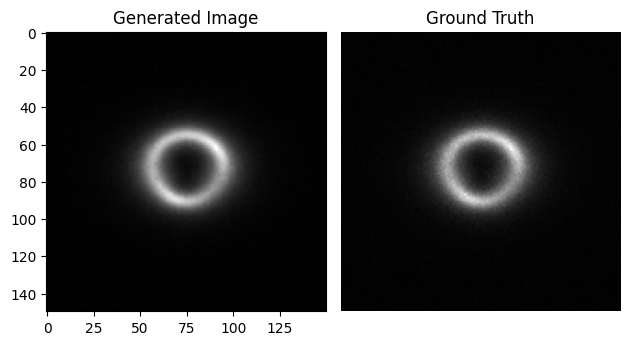

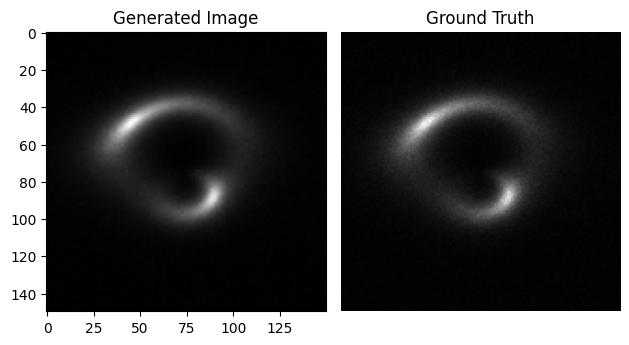

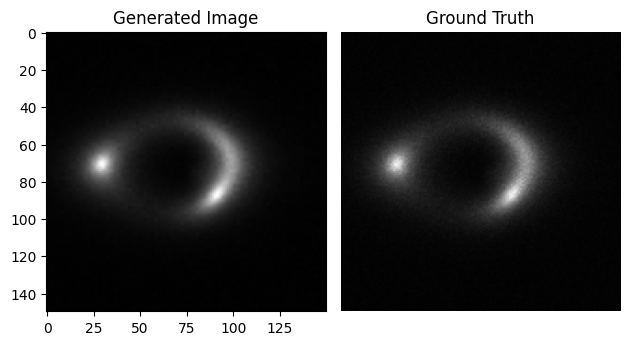

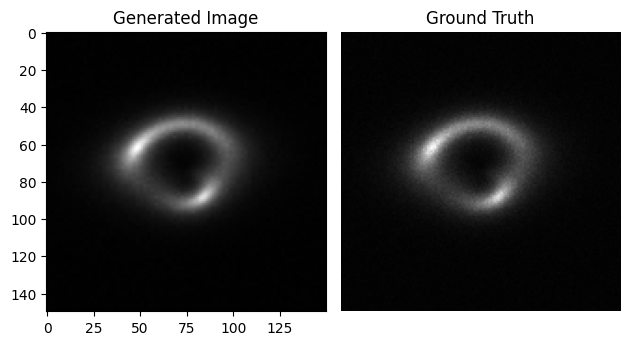

In [209]:
for i,(hr,lr) in enumerate(val_loader):
  lr = lr.to(device)
  generated = model(lr[8].unsqueeze(0))
  generated = generated.squeeze(0)
  generated = generated.permute(1, 2 ,0)

  hr = hr[8]
  hr = hr.permute(1,2,0)


  fig, (ax1, ax2) = plt.subplots(1, 2)

  # plot the generated image on the left subplot
  plt.axis("off")
  ax1.imshow(generated.detach().cpu().numpy(),cmap='gray')
  ax1.set_title('Generated Image')

  # plot the high-resolution image on the right subplot
  plt.axis("off")
  ax2.imshow(hr,cmap='gray')
  ax2.set_title('Ground Truth')

  # show the figure
  plt.axis("off")
  plt.tight_layout()
  plt.show()
  if i > 2:
    break

In [211]:
torch.save(model.state_dict(), "/content/superres.pth")